## Random Forest and Decision Tree at Titanic Data


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder , OrdinalEncoder
from sklearn.compose import ColumnTransformer
warnings.filterwarnings("ignore")

## Read Data

In [2]:
df = pd.read_csv("data/train.csv", sep=",", index_col=0)

In [3]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Examing Data

In [4]:
df["Title"]=df.Name.str.split(",",expand=True)[1].str.split(".",expand=True)[0].str.strip()
df["ClassSex"]=df["Pclass"].apply(str)+ df["Sex"]

In [5]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
Title         0
ClassSex      0
dtype: int64

## Creating column ClassSex for filling NAN Age with mean by class and sex

In [6]:
mean_age=df.groupby(["ClassSex"]).Age.mean()
mean_age.index

Index(['1female', '1male', '2female', '2male', '3female', '3male'], dtype='object', name='ClassSex')

In [7]:
df2=df[df.Age.isna()]
for item in mean_age.index:
    
    df2.loc[df2["ClassSex"]==item,"Age"]=mean_age[item]
df[df.Age.isna()]=df2

In [8]:
title_dic= {'Ms':'Miss', 'Mlle':'Miss', 'Mme':'Miss','Miss':'Miss',
            'Lady':'Mrs','Mrs':'Mrs','the Countess':'Mrs','Dona':'Mrs',
            'Rev':'Mr','Sir':'Mr','Mr':'Mr','Dr':'Mr','Major':'Mr','Col':'Mr', 'Capt':'Mr','Don':'Mr','Jonkheer':'Mr',
            'Master':'Master',
           }

In [9]:
df.replace({'Title':title_dic},inplace=True)

## Creating Catigory and Number pipes and feature transformer

In [10]:
cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),
                         OneHotEncoder(sparse=False, handle_unknown="ignore")
)

In [11]:
num_pipe = make_pipeline(SimpleImputer(strategy="median"), MinMaxScaler())

In [153]:
num_list=['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
cat_list=['Sex', 'Embarked','Title']
feature_transform = ColumnTransformer([
    ("Drop Column", 'drop', ['Cabin', 'Name', 'Ticket','ClassSex']),
    ("Num preprossing", num_pipe, num_list),
    ("Cat preprossing", cat_pipe, cat_list),
])
cat_list2=['Sex','Sex', 'Embarked','Embarked','Embarked','Title','Title','Title','Title']
complete_list =num_list+ cat_list2

## Split DF in y and X Data and in Train and Validation Data

In [69]:
y=df["Survived"]
X=df.drop(["Survived"],axis=1)

In [70]:
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  random_state=1000)


In [71]:
X_train.shape, y_train.shape

((712, 12), (712,))

## Fill NaN and Transform Strings to numbers

In [156]:
X_train_trans = feature_transform.fit_transform(X_train)

In [73]:
X_train_trans.shape

(712, 14)

## Load Define and Train Model for Decision Tree

In [74]:
from sklearn.tree import DecisionTreeClassifier

In [75]:
X_val_trans = feature_transform.transform(X_val)
score_train,score_val=[],[]
for item in range(1,20):
    model = DecisionTreeClassifier(max_depth=item)
    model.fit(X_train_trans, y_train)
    score_train.append(model.score(X_train_trans, y_train))
    score_val.append(model.score(X_val_trans, y_val))

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

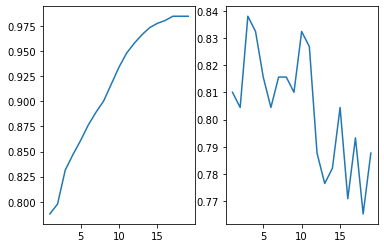

In [76]:
fig, ax = plt.subplots(1,2)
sns.lineplot(range(1,20),score_train,ax=ax[0])
sns.lineplot(range(1,20),score_val,ax=ax[1])
score_val==max(score_val)

In [77]:
model = DecisionTreeClassifier(max_depth=3)

In [78]:
model.fit(X_train_trans, y_train)

DecisionTreeClassifier(max_depth=3)

## Presition Score on Test data 

In [79]:
model.score(X_train_trans, y_train)

0.8314606741573034

## Presition Score on Validation data

In [80]:
X_val_trans = feature_transform.transform(X_val)

In [81]:
model.score(X_val_trans, y_val)

0.8379888268156425

## Crossvalidation

In [82]:
from sklearn.model_selection import cross_val_score 

In [86]:
cross_val_log = cross_val_score(model,
                                X_train_trans,
                                y_train,
                                cv=5,
                                scoring="accuracy",n_jobs=-1
)

In [87]:
cross_val_log,cross_val_log.mean()

(array([0.81818182, 0.8041958 , 0.85211268, 0.84507042, 0.81690141]),
 0.8272924258839751)

## Tree Plot from Model

In [88]:
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

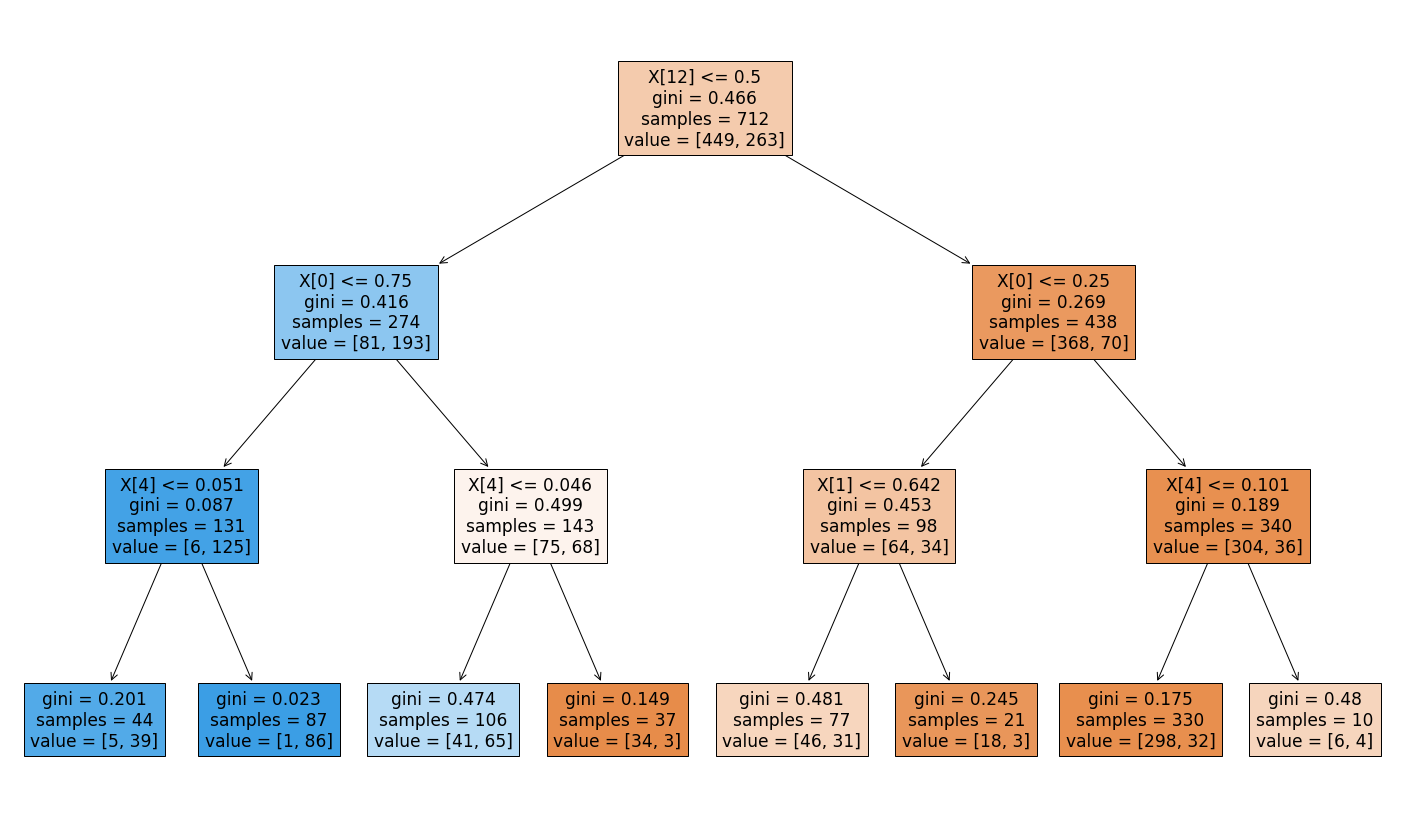

In [89]:
plt.figure(figsize=(25,15))
t = plot_tree(model, filled=True)

## Random Forest Classifier

In [90]:
from sklearn.ensemble import RandomForestClassifier 

In [107]:
rfc = RandomForestClassifier(n_estimators=400, max_depth=5,random_state=1000,n_jobs=-1)    #Hyperparam: n_estimators(number of trees)
rfc.fit(X_train_trans, y_train,)

RandomForestClassifier(max_depth=5, n_estimators=400, n_jobs=-1,
                       random_state=1000)

In [108]:
rfc.score(X_train_trans,y_train)

0.851123595505618

In [109]:
rfc.score(X_val_trans,y_val)

0.8435754189944135

In [111]:
cross_val_log = cross_val_score(rfc,
                                X_train_trans,
                                y_train,
                                cv=5,
                                scoring="accuracy",n_jobs=-1
)
print(cross_val_log, cross_val_log.mean())

[0.81818182 0.7972028  0.85211268 0.83098592 0.82394366] 0.8244853737811484


## Parameter from rfc

Text(0.5, 1.0, 'Random Forest Feature Importance')

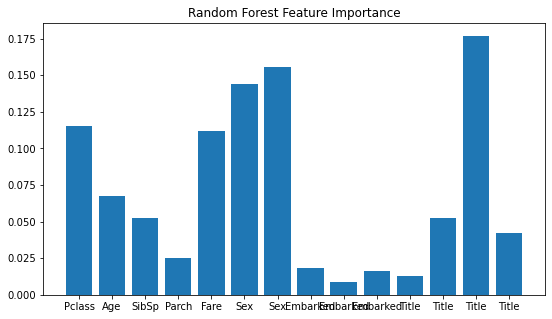

In [116]:
importance = rfc.feature_importances_
fig = plt.figure(figsize=(9,5))

plt.bar([x for x in range(len(importance))], importance, tick_label=complete_list)
plt.title('Random Forest Feature Importance')

## Accuracy is equal Score

In [117]:
from sklearn.metrics import accuracy_score

In [118]:
y_pred = rfc.predict(X_train_trans)

In [119]:
accuracy_score(y_train, y_pred)

0.851123595505618

## Difining Percision Recall and F1 Score 

In [120]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [121]:
print(f"""precision = {round(precision_score(y_train,y_pred),2)} \n 
recall = {round(recall_score(y_train,y_pred),2)}\n
f1 = {round(f1_score(y_train,y_pred),2)}""")

precision = 0.84 
 
recall = 0.74

f1 = 0.79


## Confision Matrix off True Positiv/Nagativ and False Positiv/Negativ

In [122]:
from sklearn.metrics import  confusion_matrix,ConfusionMatrixDisplay

In [123]:
confusion_matrix(y_train, y_pred,labels=model.classes_)

array([[412,  37],
       [ 69, 194]])

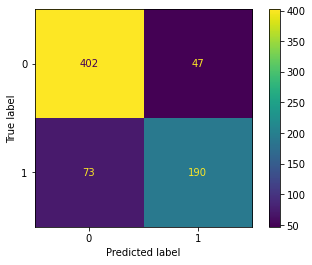

In [124]:
ConfusionMatrixDisplay.from_estimator(model,X_train_trans,y_train)


## Reciever operating curve (ROC) and Area under the curve (AUC) 

In [125]:
from sklearn.metrics import roc_curve,auc ,RocCurveDisplay

In [126]:
probs_train = rfc.predict_proba(X_train_trans)
probs_train

array([[0.90071145, 0.09928855],
       [0.1640224 , 0.8359776 ],
       [0.68737524, 0.31262476],
       ...,
       [0.80028721, 0.19971279],
       [0.53494571, 0.46505429],
       [0.09157468, 0.90842532]])

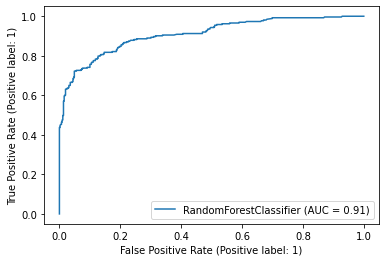

In [127]:
RocCurveDisplay.from_estimator(rfc,X_train_trans,y_train)

## Getting Flase positiv rate True positive rate and Tresurehold from ROC 

In [128]:
fpr,tpr,tresurehold = roc_curve(y_train,probs_train[:,1])

## Finding best Tresurehold index fron ROC

In [129]:
max_index=np.argmax(tpr-fpr)
max_index

57

In [130]:
tresurehold[max_index]

0.5456870352125538

## get the Area unter the Curve (AUC)

In [131]:
auc(fpr,tpr)

0.909168663781788

## Get new perdiction with new Tresurehold

In [132]:
prob_train_df=pd.DataFrame(probs_train)

In [133]:
prob_train_df["tresurhold"]=tresurehold[max_index]

In [134]:
prob_train_df.head()

,0,1,tresurhold
0,0.900711,0.099289,0.545687
1,0.164022,0.835978,0.545687
2,0.687375,0.312625,0.545687
3,0.684602,0.315398,0.545687
4,0.901276,0.098724,0.545687


In [135]:
prob_train_df["new_prediction"]=(prob_train_df[1]>prob_train_df["tresurhold"]).astype(int)

In [136]:
prob_train_df.head()

,0,1,tresurhold,new_prediction
0,0.900711,0.099289,0.545687,0
1,0.164022,0.835978,0.545687,1
2,0.687375,0.312625,0.545687,0
3,0.684602,0.315398,0.545687,0
4,0.901276,0.098724,0.545687,0


## Differentce from new (0.5456870) and old (.5)  Tresurehold on Testdata

In [137]:
acc_test=[]

In [138]:
acc_test.append(accuracy_score(y_train, model.predict(X_train_trans)))

In [139]:
acc_test.append(accuracy_score(y_train, prob_train_df["new_prediction"]))

In [140]:
acc_test

[0.8314606741573034, 0.8651685393258427]

<AxesSubplot:>

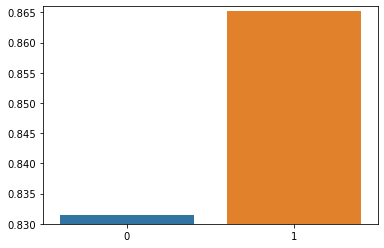

In [141]:
plt.axis((0,1,.83,.866))
sns.barplot([0,1],acc_test)

## Differentce from new (0.5456870) and old (.5) Tresurehold on Valuation Data

In [142]:
props_val = model.predict_proba(X_val_trans)

In [143]:
prob_val_df = pd.DataFrame(props_val)

In [144]:
prob_val_df["tresurhold"]=tresurehold[max_index]

In [145]:
prob_val_df["new_prediction"]=(prob_val_df[1]>prob_val_df["tresurhold"]).astype(int)

In [146]:
acc_val= []

In [147]:
acc_val.append(accuracy_score(y_val,model.predict(X_val_trans)))

In [148]:
acc_val.append(accuracy_score(y_val,prob_val_df["new_prediction"]))

In [149]:
acc_val

[0.8379888268156425, 0.8379888268156425]

<AxesSubplot:>

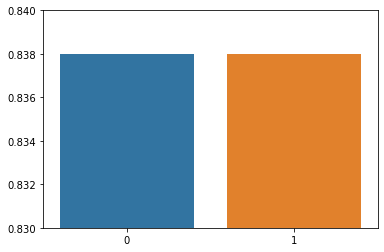

In [151]:
plt.axis((0,1,.83,.84))
sns.barplot([0,1],acc_val)

## Creating datafile for Kaggle

In [165]:
test = pd.read_csv("data/test.csv",sep=",",index_col = 0)
test["Title"]=test.Name.str.split(",",expand=True)[1].str.split(".",expand=True)[0].str.strip()
test["ClassSex"]=test["Pclass"].apply(str)+ df["Sex"]
df2=test[test.Age.isna()]
for item in mean_age.index:
    df2.loc[df2["ClassSex"]==item,"Age"]=mean_age[item]
test[test.Age.isna()]=df2
test.replace({'Title':title_dic},inplace=True)
test_trans = feature_transform.transform(test)
test_pred = model.predict(test_trans)
test_props_val = model.predict_proba(test_trans)
test_prob_val_df = pd.DataFrame(test_props_val)
test_prob_val_df["tresurhold"]=tresurehold[max_index]
test_prob_val_df["new_prediction"]=(test_prob_val_df[1]>test_prob_val_df["tresurhold"]).astype(int)
kraggle = pd.DataFrame(test.index)
kraggle["Survived"]=test_pred#test_prob_val_df["new_prediction"]
kraggle.set_index("PassengerId")
kraggle.to_csv("data/kraggle_rfc.csv",index = False)